# OpenAI Gym Pendulum
## Solved using Q learning and Decision trees (LightGBM)

#### References
Inspiration for this project:
- https://towardsdatascience.com/reinforcement-learning-q-learning-with-decision-trees-ecb1215d9131
- https://www.semanticscholar.org/paper/Reinforcement-Learning-with-Decision-Trees-Pyeatt/f9b30e1f6d85cb77e95ff1d580ee67d7406f1dd6?p2df

Github Repo solving OpenAI pendulum using the same method:
- https://github.com/palmbook/cartpole

In [93]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from collections import deque
import random
import sklearn.ensemble
import sklearn.tree
from sklearn.exceptions import NotFittedError
from lightgbm import LGBMRegressor
import sklearn.multioutput
import timeit

In [94]:
class Treepredictor():
    
    #init model and hyperparameters
    def __init__(self, env, exploration_min = 0.05, exploration_decay = 0.996, gamma = 0.95, batch_size = 32):
        #models hyperparameters
        self.env = env
        self.batch_size = batch_size
        self.action_shape = 2
        self.exploration_min = exploration_min
        self.exploration_decay = exploration_decay
        self.exploration_rate = 1
        self.gamma = gamma
        
        self.memory = deque(maxlen=2000)
        
        #model architecture
        self.forest = LGBMRegressor(n_estimators=100, n_jobs=-1)
        self.regressor = sklearn.multioutput.MultiOutputRegressor(self.forest)
        
        
    #select an action, either random or from model
    def select_action(self,state):
        #this ensures that the model explores the environment and accumulates memory (stochasticity)
        if np.random.rand() < self.exploration_rate:
            return self.env.action_space.sample()
        
        try:
            q_values = self.regressor.predict(state.reshape(1, -1))
            return np.argmax(q_values[0])
        except NotFittedError as e:
            return 0
    
    
    #add an experience to the model's memory
    def remember(self,last_state,action,reward,next_state,done):
        self.memory.append((last_state,action,reward,next_state,done))

        
    #replay experiences from memory and fit the model
    def experience_replay(self):

        if len(self.memory) < self.batch_size:
            return

        batch = self.memory

        X = np.empty((0,4))
        y = np.empty((0,2))
        for last_state, action, reward, next_state, done in batch:
            q_update = reward
            if not done:
                try:
                    q_update = (reward + self.gamma * np.amax(self.regressor.predict(next_state.reshape(1, -1))[0]))
                except NotFittedError as e:
                    q_update = reward 
            try:
                q_values = self.regressor.predict(last_state.reshape(1, -1))
            except NotFittedError as e:
                q_values = np.zeros(self.action_shape).reshape(1, -1)
            q_values[0][action] = q_update

            X = np.append(X,np.array([last_state]),axis=0)
            y = np.append(y,np.array([q_values[0]]),axis=0)
            
    
        #fit
        self.regressor.fit(X,y)

        #decay exploration rate to reduce randomness
        if self.exploration_rate > self.exploration_min:
            self.exploration_rate *= self.exploration_decay

In [95]:
class MetricsLogger():
    
    def __init__(self):
        self.episodes_steps = np.array([])
        self.episodes_before_solve = np.array([])
        self.runs_logs = np.empty((0,3))
        
    def reset_run(self):
        self.episodes_steps = np.array([])
        self.episodes_before_solve = np.array([])

In [96]:
#Init environment
env = gym.make('CartPole-v0')
env._max_episode_steps = 200

#Init Logger
logs = MetricsLogger()

In [97]:
#training loop

for run_i in range(5):
    start = timeit.default_timer()
    num_solved = 0
    episode_i = 0
    episode_i_before_solve = 0
    logs.reset_run()
    
    #Init model
    model = Treepredictor(env)
    
    while num_solved < 5 and episode_i < 2000:
        episode_i += 1
        last_state = env.reset()
        steps = 0
        total_reward = 0
        episode_i_before_solve += 1
        
        while True:
            running_loss = 0
            #uncomment this to display simulation 
    #         env.render()
            steps += 1
            action = model.select_action(last_state)
            next_state, reward, done, info = env.step(action)
            reward = reward if not done else -reward
            model.remember(last_state,action,reward,next_state,done)

            total_reward += reward

            if done:
                print("Episode {} finished after {} steps with {} total reward".format(episode_i,steps,total_reward))
                if total_reward > 190:
                    logs.episodes_before_solve = np.append(logs.episodes_before_solve,episode_i_before_solve)
                    episode_i_before_solve = 0
                    num_solved += 1
                break

            last_state = next_state

        model.experience_replay()
        logs.episodes_steps = np.append(logs.episodes_steps,steps)

    stop = timeit.default_timer()
    print("Run {} done in {}".format(run_i,stop - start))
    
    logs.runs_logs = np.append(logs.runs_logs,[[logs.episodes_steps,logs.episodes_before_solve,stop - start]],axis=0)
    
env.close()

Episode 1 finished after 16 steps with 14.0 total reward
Episode 2 finished after 26 steps with 24.0 total reward
Episode 3 finished after 30 steps with 28.0 total reward
Episode 4 finished after 38 steps with 36.0 total reward
Episode 5 finished after 46 steps with 44.0 total reward
Episode 6 finished after 14 steps with 12.0 total reward
Episode 7 finished after 33 steps with 31.0 total reward
Episode 8 finished after 29 steps with 27.0 total reward
Episode 9 finished after 43 steps with 41.0 total reward
Episode 10 finished after 36 steps with 34.0 total reward
Episode 11 finished after 34 steps with 32.0 total reward
Episode 12 finished after 21 steps with 19.0 total reward
Episode 13 finished after 19 steps with 17.0 total reward
Episode 14 finished after 17 steps with 15.0 total reward
Episode 15 finished after 21 steps with 19.0 total reward
Episode 16 finished after 31 steps with 29.0 total reward
Episode 17 finished after 26 steps with 24.0 total reward
Episode 18 finished aft

Episode 142 finished after 36 steps with 34.0 total reward
Episode 143 finished after 16 steps with 14.0 total reward
Episode 144 finished after 19 steps with 17.0 total reward
Episode 145 finished after 18 steps with 16.0 total reward
Episode 146 finished after 23 steps with 21.0 total reward
Episode 147 finished after 93 steps with 91.0 total reward
Episode 148 finished after 14 steps with 12.0 total reward
Episode 149 finished after 19 steps with 17.0 total reward
Episode 150 finished after 32 steps with 30.0 total reward
Episode 151 finished after 19 steps with 17.0 total reward
Episode 152 finished after 15 steps with 13.0 total reward
Episode 153 finished after 28 steps with 26.0 total reward
Episode 154 finished after 61 steps with 59.0 total reward
Episode 155 finished after 137 steps with 135.0 total reward
Episode 156 finished after 41 steps with 39.0 total reward
Episode 157 finished after 49 steps with 47.0 total reward
Episode 158 finished after 16 steps with 14.0 total re

Episode 281 finished after 83 steps with 81.0 total reward
Episode 282 finished after 54 steps with 52.0 total reward
Episode 283 finished after 16 steps with 14.0 total reward
Episode 284 finished after 24 steps with 22.0 total reward
Episode 285 finished after 93 steps with 91.0 total reward
Episode 286 finished after 37 steps with 35.0 total reward
Episode 287 finished after 17 steps with 15.0 total reward
Episode 288 finished after 50 steps with 48.0 total reward
Episode 289 finished after 18 steps with 16.0 total reward
Episode 290 finished after 38 steps with 36.0 total reward
Episode 291 finished after 12 steps with 10.0 total reward
Episode 292 finished after 35 steps with 33.0 total reward
Episode 293 finished after 11 steps with 9.0 total reward
Episode 294 finished after 13 steps with 11.0 total reward
Episode 295 finished after 101 steps with 99.0 total reward
Episode 296 finished after 12 steps with 10.0 total reward
Episode 297 finished after 13 steps with 11.0 total rewa

Episode 420 finished after 64 steps with 62.0 total reward
Episode 421 finished after 139 steps with 137.0 total reward
Episode 422 finished after 54 steps with 52.0 total reward
Episode 423 finished after 10 steps with 8.0 total reward
Episode 424 finished after 53 steps with 51.0 total reward
Episode 425 finished after 14 steps with 12.0 total reward
Episode 426 finished after 13 steps with 11.0 total reward
Episode 427 finished after 11 steps with 9.0 total reward
Episode 428 finished after 52 steps with 50.0 total reward
Episode 429 finished after 66 steps with 64.0 total reward
Episode 430 finished after 17 steps with 15.0 total reward
Episode 431 finished after 118 steps with 116.0 total reward
Episode 432 finished after 54 steps with 52.0 total reward
Episode 433 finished after 76 steps with 74.0 total reward
Episode 434 finished after 91 steps with 89.0 total reward
Episode 435 finished after 95 steps with 93.0 total reward
Episode 436 finished after 116 steps with 114.0 total 

Episode 84 finished after 10 steps with 8.0 total reward
Episode 85 finished after 63 steps with 61.0 total reward
Episode 86 finished after 53 steps with 51.0 total reward
Episode 87 finished after 49 steps with 47.0 total reward
Episode 88 finished after 24 steps with 22.0 total reward
Episode 89 finished after 29 steps with 27.0 total reward
Episode 90 finished after 15 steps with 13.0 total reward
Episode 91 finished after 13 steps with 11.0 total reward
Episode 92 finished after 40 steps with 38.0 total reward
Episode 93 finished after 19 steps with 17.0 total reward
Episode 94 finished after 11 steps with 9.0 total reward
Episode 95 finished after 21 steps with 19.0 total reward
Episode 96 finished after 21 steps with 19.0 total reward
Episode 97 finished after 10 steps with 8.0 total reward
Episode 98 finished after 12 steps with 10.0 total reward
Episode 99 finished after 28 steps with 26.0 total reward
Episode 100 finished after 22 steps with 20.0 total reward
Episode 101 fini

Episode 224 finished after 39 steps with 37.0 total reward
Episode 225 finished after 15 steps with 13.0 total reward
Episode 226 finished after 100 steps with 98.0 total reward
Episode 227 finished after 97 steps with 95.0 total reward
Episode 228 finished after 64 steps with 62.0 total reward
Episode 229 finished after 76 steps with 74.0 total reward
Episode 230 finished after 18 steps with 16.0 total reward
Episode 231 finished after 22 steps with 20.0 total reward
Episode 232 finished after 27 steps with 25.0 total reward
Episode 233 finished after 16 steps with 14.0 total reward
Episode 234 finished after 32 steps with 30.0 total reward
Episode 235 finished after 11 steps with 9.0 total reward
Episode 236 finished after 117 steps with 115.0 total reward
Episode 237 finished after 22 steps with 20.0 total reward
Episode 238 finished after 19 steps with 17.0 total reward
Episode 239 finished after 15 steps with 13.0 total reward
Episode 240 finished after 15 steps with 13.0 total re

Episode 363 finished after 60 steps with 58.0 total reward
Episode 364 finished after 138 steps with 136.0 total reward
Episode 365 finished after 61 steps with 59.0 total reward
Episode 366 finished after 95 steps with 93.0 total reward
Episode 367 finished after 142 steps with 140.0 total reward
Episode 368 finished after 18 steps with 16.0 total reward
Episode 369 finished after 79 steps with 77.0 total reward
Episode 370 finished after 87 steps with 85.0 total reward
Episode 371 finished after 23 steps with 21.0 total reward
Episode 372 finished after 95 steps with 93.0 total reward
Episode 373 finished after 10 steps with 8.0 total reward
Episode 374 finished after 28 steps with 26.0 total reward
Episode 375 finished after 89 steps with 87.0 total reward
Episode 376 finished after 64 steps with 62.0 total reward
Episode 377 finished after 11 steps with 9.0 total reward
Episode 378 finished after 34 steps with 32.0 total reward
Episode 379 finished after 95 steps with 93.0 total re

Episode 64 finished after 25 steps with 23.0 total reward
Episode 65 finished after 70 steps with 68.0 total reward
Episode 66 finished after 26 steps with 24.0 total reward
Episode 67 finished after 17 steps with 15.0 total reward
Episode 68 finished after 30 steps with 28.0 total reward
Episode 69 finished after 30 steps with 28.0 total reward
Episode 70 finished after 10 steps with 8.0 total reward
Episode 71 finished after 38 steps with 36.0 total reward
Episode 72 finished after 61 steps with 59.0 total reward
Episode 73 finished after 22 steps with 20.0 total reward
Episode 74 finished after 28 steps with 26.0 total reward
Episode 75 finished after 36 steps with 34.0 total reward
Episode 76 finished after 16 steps with 14.0 total reward
Episode 77 finished after 19 steps with 17.0 total reward
Episode 78 finished after 30 steps with 28.0 total reward
Episode 79 finished after 39 steps with 37.0 total reward
Episode 80 finished after 28 steps with 26.0 total reward
Episode 81 fini

Episode 204 finished after 34 steps with 32.0 total reward
Episode 205 finished after 22 steps with 20.0 total reward
Episode 206 finished after 57 steps with 55.0 total reward
Episode 207 finished after 28 steps with 26.0 total reward
Episode 208 finished after 31 steps with 29.0 total reward
Episode 209 finished after 82 steps with 80.0 total reward
Episode 210 finished after 14 steps with 12.0 total reward
Episode 211 finished after 60 steps with 58.0 total reward
Episode 212 finished after 64 steps with 62.0 total reward
Episode 213 finished after 45 steps with 43.0 total reward
Episode 214 finished after 54 steps with 52.0 total reward
Episode 215 finished after 16 steps with 14.0 total reward
Episode 216 finished after 14 steps with 12.0 total reward
Episode 217 finished after 20 steps with 18.0 total reward
Episode 218 finished after 68 steps with 66.0 total reward
Episode 219 finished after 18 steps with 16.0 total reward
Episode 220 finished after 59 steps with 57.0 total rewa

Episode 343 finished after 111 steps with 109.0 total reward
Episode 344 finished after 114 steps with 112.0 total reward
Episode 345 finished after 114 steps with 112.0 total reward
Episode 346 finished after 84 steps with 82.0 total reward
Episode 347 finished after 152 steps with 150.0 total reward
Episode 348 finished after 104 steps with 102.0 total reward
Episode 349 finished after 55 steps with 53.0 total reward
Episode 350 finished after 13 steps with 11.0 total reward
Episode 351 finished after 77 steps with 75.0 total reward
Episode 352 finished after 20 steps with 18.0 total reward
Episode 353 finished after 84 steps with 82.0 total reward
Episode 354 finished after 107 steps with 105.0 total reward
Episode 355 finished after 12 steps with 10.0 total reward
Episode 356 finished after 38 steps with 36.0 total reward
Episode 357 finished after 17 steps with 15.0 total reward
Episode 358 finished after 84 steps with 82.0 total reward
Episode 359 finished after 28 steps with 26.

Episode 20 finished after 17 steps with 15.0 total reward
Episode 21 finished after 11 steps with 9.0 total reward
Episode 22 finished after 16 steps with 14.0 total reward
Episode 23 finished after 26 steps with 24.0 total reward
Episode 24 finished after 15 steps with 13.0 total reward
Episode 25 finished after 15 steps with 13.0 total reward
Episode 26 finished after 17 steps with 15.0 total reward
Episode 27 finished after 31 steps with 29.0 total reward
Episode 28 finished after 14 steps with 12.0 total reward
Episode 29 finished after 15 steps with 13.0 total reward
Episode 30 finished after 14 steps with 12.0 total reward
Episode 31 finished after 17 steps with 15.0 total reward
Episode 32 finished after 12 steps with 10.0 total reward
Episode 33 finished after 45 steps with 43.0 total reward
Episode 34 finished after 38 steps with 36.0 total reward
Episode 35 finished after 29 steps with 27.0 total reward
Episode 36 finished after 43 steps with 41.0 total reward
Episode 37 fini

Episode 161 finished after 16 steps with 14.0 total reward
Episode 162 finished after 17 steps with 15.0 total reward
Episode 163 finished after 19 steps with 17.0 total reward
Episode 164 finished after 12 steps with 10.0 total reward
Episode 165 finished after 22 steps with 20.0 total reward
Episode 166 finished after 102 steps with 100.0 total reward
Episode 167 finished after 22 steps with 20.0 total reward
Episode 168 finished after 21 steps with 19.0 total reward
Episode 169 finished after 19 steps with 17.0 total reward
Episode 170 finished after 13 steps with 11.0 total reward
Episode 171 finished after 70 steps with 68.0 total reward
Episode 172 finished after 16 steps with 14.0 total reward
Episode 173 finished after 94 steps with 92.0 total reward
Episode 174 finished after 14 steps with 12.0 total reward
Episode 175 finished after 153 steps with 151.0 total reward
Episode 176 finished after 22 steps with 20.0 total reward
Episode 177 finished after 32 steps with 30.0 total 

Episode 300 finished after 13 steps with 11.0 total reward
Episode 301 finished after 73 steps with 71.0 total reward
Episode 302 finished after 13 steps with 11.0 total reward
Episode 303 finished after 12 steps with 10.0 total reward
Episode 304 finished after 22 steps with 20.0 total reward
Episode 305 finished after 21 steps with 19.0 total reward
Episode 306 finished after 35 steps with 33.0 total reward
Episode 307 finished after 51 steps with 49.0 total reward
Episode 308 finished after 106 steps with 104.0 total reward
Episode 309 finished after 21 steps with 19.0 total reward
Episode 310 finished after 63 steps with 61.0 total reward
Episode 311 finished after 13 steps with 11.0 total reward
Episode 312 finished after 37 steps with 35.0 total reward
Episode 313 finished after 96 steps with 94.0 total reward
Episode 314 finished after 39 steps with 37.0 total reward
Episode 315 finished after 50 steps with 48.0 total reward
Episode 316 finished after 80 steps with 78.0 total re

Episode 7 finished after 28 steps with 26.0 total reward
Episode 8 finished after 29 steps with 27.0 total reward
Episode 9 finished after 9 steps with 7.0 total reward
Episode 10 finished after 13 steps with 11.0 total reward
Episode 11 finished after 11 steps with 9.0 total reward
Episode 12 finished after 39 steps with 37.0 total reward
Episode 13 finished after 50 steps with 48.0 total reward
Episode 14 finished after 12 steps with 10.0 total reward
Episode 15 finished after 20 steps with 18.0 total reward
Episode 16 finished after 10 steps with 8.0 total reward
Episode 17 finished after 32 steps with 30.0 total reward
Episode 18 finished after 21 steps with 19.0 total reward
Episode 19 finished after 20 steps with 18.0 total reward
Episode 20 finished after 16 steps with 14.0 total reward
Episode 21 finished after 13 steps with 11.0 total reward
Episode 22 finished after 47 steps with 45.0 total reward
Episode 23 finished after 14 steps with 12.0 total reward
Episode 24 finished a

Episode 148 finished after 33 steps with 31.0 total reward
Episode 149 finished after 41 steps with 39.0 total reward
Episode 150 finished after 45 steps with 43.0 total reward
Episode 151 finished after 49 steps with 47.0 total reward
Episode 152 finished after 22 steps with 20.0 total reward
Episode 153 finished after 20 steps with 18.0 total reward
Episode 154 finished after 29 steps with 27.0 total reward
Episode 155 finished after 15 steps with 13.0 total reward
Episode 156 finished after 15 steps with 13.0 total reward
Episode 157 finished after 15 steps with 13.0 total reward
Episode 158 finished after 16 steps with 14.0 total reward
Episode 159 finished after 15 steps with 13.0 total reward
Episode 160 finished after 13 steps with 11.0 total reward
Episode 161 finished after 15 steps with 13.0 total reward
Episode 162 finished after 24 steps with 22.0 total reward
Episode 163 finished after 48 steps with 46.0 total reward
Episode 164 finished after 20 steps with 18.0 total rewa

Episode 287 finished after 10 steps with 8.0 total reward
Episode 288 finished after 16 steps with 14.0 total reward
Episode 289 finished after 29 steps with 27.0 total reward
Episode 290 finished after 167 steps with 165.0 total reward
Episode 291 finished after 190 steps with 188.0 total reward
Episode 292 finished after 20 steps with 18.0 total reward
Episode 293 finished after 185 steps with 183.0 total reward
Episode 294 finished after 99 steps with 97.0 total reward
Episode 295 finished after 149 steps with 147.0 total reward
Episode 296 finished after 17 steps with 15.0 total reward
Episode 297 finished after 54 steps with 52.0 total reward
Episode 298 finished after 21 steps with 19.0 total reward
Episode 299 finished after 20 steps with 18.0 total reward
Episode 300 finished after 92 steps with 90.0 total reward
Episode 301 finished after 53 steps with 51.0 total reward
Episode 302 finished after 65 steps with 63.0 total reward
Episode 303 finished after 39 steps with 37.0 tot

Episode 425 finished after 102 steps with 100.0 total reward
Episode 426 finished after 108 steps with 106.0 total reward
Episode 427 finished after 200 steps with 198.0 total reward
Episode 428 finished after 160 steps with 158.0 total reward
Episode 429 finished after 138 steps with 136.0 total reward
Episode 430 finished after 116 steps with 114.0 total reward
Episode 431 finished after 200 steps with 198.0 total reward
Episode 432 finished after 200 steps with 198.0 total reward
Episode 433 finished after 200 steps with 198.0 total reward
Run 4 done in 745.3748150000029


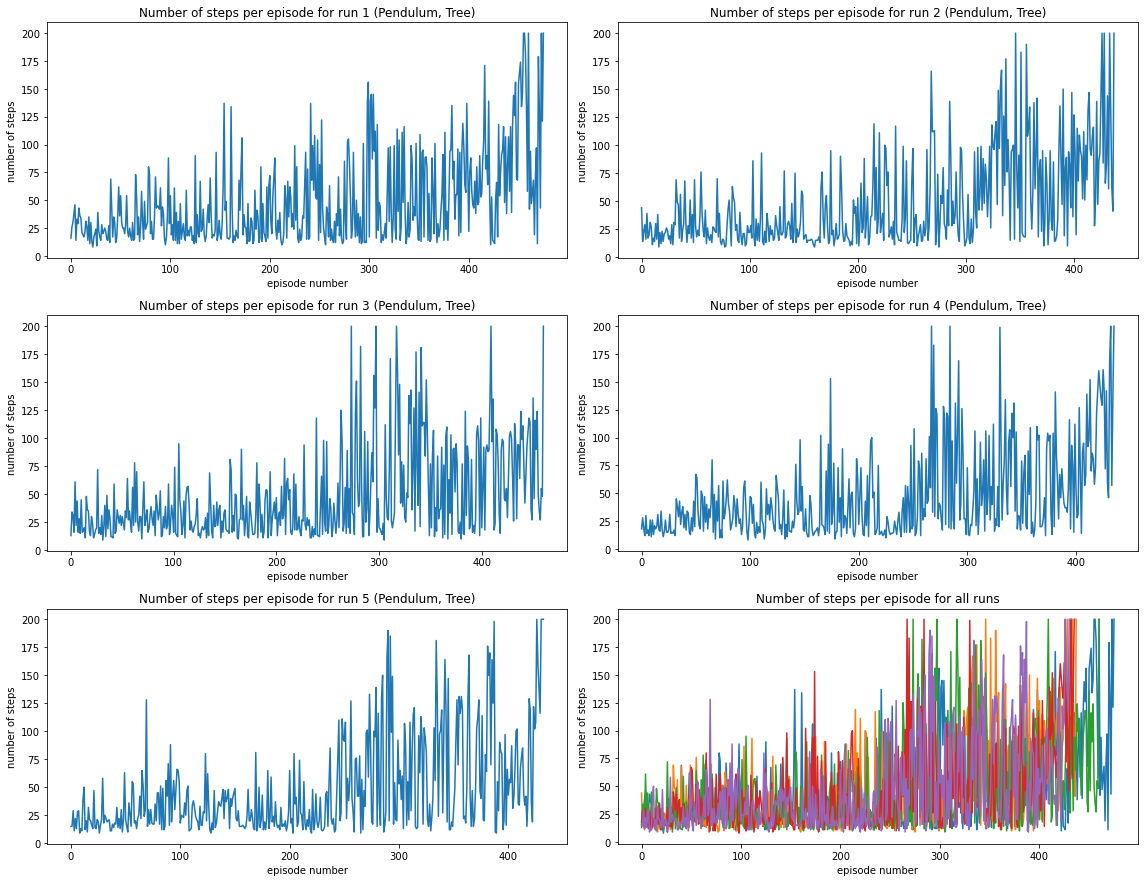

In [98]:
plt.figure(figsize=(16,16))
count = 0
for run_log in logs.runs_logs:
    count += 1
    plt.subplot(4,2,count,title="Number of steps per episode for run {} (Pendulum, Tree)".format(count))
    plt.plot(run_log[0])
    plt.xlabel("episode number")
    plt.ylabel("number of steps")
    
plt.subplot(4,2,count+1,title="Number of steps per episode for all runs")
for run_log in logs.runs_logs:
    plt.plot(run_log[0])
plt.xlabel("episode number")
plt.ylabel("number of steps")
    
plt.tight_layout()
plt.show;

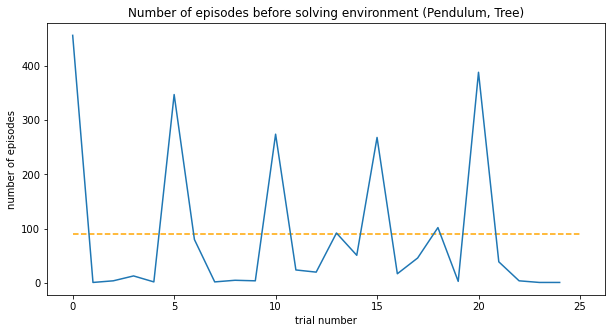

In [99]:
#####
# Everytime the env is solved, we look at the number of episodes it took before solving it.
# The peaks are at the start of each run, since the model is not yet trained.
####
cumul_episodes_before_solve = np.array([])
for run_log in logs.runs_logs:
    cumul_episodes_before_solve = np.append(cumul_episodes_before_solve,run_log[1])

average_episiodes_before_solve = np.sum(cumul_episodes_before_solve)/len(cumul_episodes_before_solve)

plt.figure(figsize=(10,5))
plt.plot(cumul_episodes_before_solve)
plt.hlines(average_episiodes_before_solve,0,25,linestyles="dashed",colors="orange")
plt.title("Number of episodes before solving environment (Pendulum, Tree)")
plt.xlabel("trial number")
plt.ylabel("number of episodes")
plt.show;

In [100]:
cumul_steps_per_eps = np.array([])
cumul_time_per_run = np.array([])
for run_log in logs.runs_logs:
    cumul_steps_per_eps = np.append(cumul_steps_per_eps,run_log[0])
    cumul_time_per_run = np.append(cumul_time_per_run,run_log[2])

print("\nTotal number of steps per run:")
run_count = 0
for run_log in logs.runs_logs:
    run_count += 1
    print("\tRun {}, total steps : {}".format(run_count,np.sum(run_log[0])))

print("\nTotal number of steps: {}".format(np.sum(cumul_steps_per_eps)))
print("Average number of steps per run: {}".format(np.sum(cumul_steps_per_eps)/5))
print("\nAverage time per run: {} seconds".format(np.sum(cumul_time_per_run)/5))
print("Average time per step: {:.2f} seconds".format(np.sum(cumul_steps_per_eps)/np.sum(cumul_time_per_run)))


Total number of steps per run:
	Run 1, total steps : 23254.0
	Run 2, total steps : 20910.0
	Run 3, total steps : 21963.0
	Run 4, total steps : 20565.0
	Run 5, total steps : 20635.0

Total number of steps: 107327.0
Average number of steps per run: 21465.4

Average time per run: 766.7161206799996 seconds
Average time per step: 28.00 seconds
